# Restaurant Review Analysis

<a href="https://colab.research.google.com/github/mjsmagalhaes/examples-datascience/blob/main/restaurant_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


A notebook investigating a [restaurant review dataset](https://www.kaggle.com/bulentsiyah/restaurant-reviews) from kaggle.

The solution here uses a Neural Network (NN) as a scoring system and a Decision Tree (DT, which is just making the solution worse :) -- but it is a fun little test casding classifiers) to "decide" if a score means a good review or a bad one.

Neither the NN nor the DT is doing a good job :).

**This is a work in progress.**


In [1]:
%load_ext autoreload
%autoreload 2

# Colab
# !git clone https://github.com/mjsmagalhaes/examples-datascience.git repo
# %cd repo
# %pip install -r _requirements/dslib.txt

### Importing Libraries

In [16]:
import math

import altair as alt
import graphviz as graph
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export_text, plot_tree

from dslib import pandas_from_csv
from dslib.nlp import extract_vocab, vectorize
from dslib.analysis import evaluate

### Loading Dataset

In [3]:
raw = pandas_from_csv('data/Restaurant_Reviews.csv')
corpus = raw['Review'].to_list()

## Create Sets: Train, Validation and TestCreate Sets: Train, Validation and Test

In [4]:
# Train: 60%; Valid: 20%; Test: 20%
xTV, testCorpus, yTV, testTarget = train_test_split(
    raw['Review'], 
    raw['Liked'], 
    test_size=0.2, random_state=0
)

trainCorpus, validCorpus, trainTarget, validTarget = train_test_split(
    xTV, yTV, 
    test_size=0.25, random_state=0
)

## Extract Corpus

### Create Vocabulary

In [5]:
# Find "meaningful" words in the corpus
vocabs = extract_vocab(trainCorpus)

### Extract Corpus

In [6]:
# Transform corpus sentences into one-hot vectors
trainX = pd.DataFrame(vectorize(trainCorpus, vocabs), columns=vocabs)
validX = pd.DataFrame(vectorize(validCorpus, vocabs), columns=vocabs)
testX = pd.DataFrame(vectorize(testCorpus, vocabs), columns=vocabs)

In [7]:
print(trainX.shape, trainTarget.shape, len(vocabs))

(600, 1090) (600,) 1090


## Building Model

In [8]:
initializer = tf.keras.initializers.Orthogonal()
constraint = tf.keras.constraints.NonNeg()

n_dim = len(vocabs)

# Neural Network Model
model = Sequential([
    Dense(
        units=math.ceil(n_dim/2), activation='tanh', input_shape=(n_dim,),
        kernel_initializer=initializer, 
        # kernel_constraint=constraint,
        # kernel_regularizer='l2'
    ),
     Dense(
        units=math.ceil(n_dim/4), activation='tanh', 
        kernel_initializer=initializer, 
        # kernel_constraint=constraint, 
        # kernel_regularizer='l2'
    ),
    Dense(
        units=math.ceil(n_dim/8), activation='tanh', 
        kernel_initializer=initializer, 
        # kernel_constraint=constraint, 
        # kernel_regularizer='l2'
    ),
    Dense(
        units=1,activation='tanh'
    )
])

model.compile(
    optimizer=SGD(momentum=0.4,learning_rate=0.025),
    loss="mean_squared_error",
)

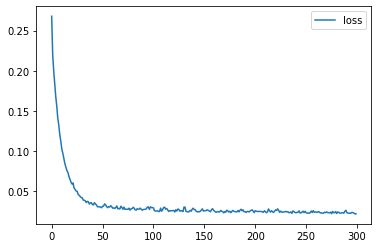

In [9]:
th = model.fit(
    trainX,
    trainTarget,
    epochs=300,
    # steps_per_epoch=1,
    # validation_split=None, 
    verbose=0
)

pd.DataFrame(th.history.get('loss'), columns=['loss']).plot.line()
validPred = model.predict(validX)

In [10]:
tree = DecisionTreeClassifier(max_depth=4).fit(validPred, validTarget)
# Save Tree
g = graph.Source(export_graphviz(tree))
# g
# g.render(filename='tree')

## Evaluating Models

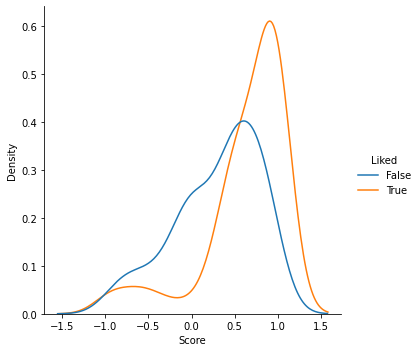

In [11]:
# Neural Network Score
testPred = model.predict(testX)

# Plot Neural Network Score Distribution
z = pd.DataFrame(testPred, columns=['Score'])
z = z.join(testTarget.reset_index())

sns.displot(z, x='Score', hue='Liked', kind='kde')

In [12]:
chart_1 = alt.Chart(z).transform_density(
    density='Score',
    # bandwidth=0.2,
    groupby=['Liked'],
    extent= [-1, 1],
    counts = True,
    steps=200,
    as_ = ["Score", "Density"]
).mark_area(line=True, opacity=0.6).encode(
    alt.X('Score:Q'),
    alt.Y('Density:Q', stack=None),
    alt.Color('Liked:N')
).interactive()

chart_2 = alt.Chart(z).mark_bar().encode(
    alt.X('Score', bin=alt.BinParams(step=0.05, extent=[-1, 1])),
    alt.Y('count()', stack='normalize'),
    color='Liked:N',
    tooltip='count()'
).interactive()

chart_1 | chart_2

alt.HConcatChart(...)

In both density estimation figures above they extend beyond the [-1,1] range of the hyperbolic tangent that is the activation function of the output layer. The Neural Network is having a hard time finding a implementing a function that can provide good separability for those classes.

In [13]:
# Neural Networking "Post-Processing"
testPred_Tree = tree.predict(testPred)
testPred_NN = list(map(lambda y: 0 if y < 0.55 else 1, testPred))

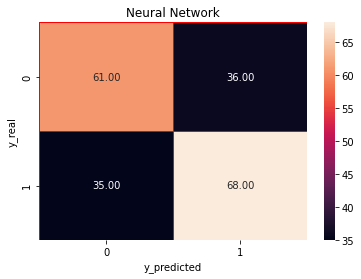

              precision    recall  f1-score   support

       False       0.64      0.63      0.63        97
        True       0.65      0.66      0.66       103

    accuracy                           0.65       200
   macro avg       0.64      0.64      0.64       200
weighted avg       0.64      0.65      0.64       200



array([[61, 36],
       [35, 68]], dtype=int64)

In [17]:
evaluate(testTarget, testPred_NN, title='Neural Network')

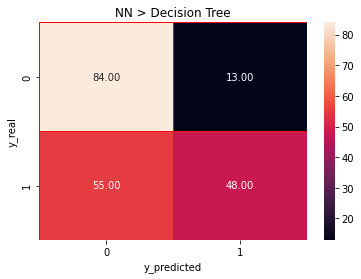

              precision    recall  f1-score   support

       False       0.60      0.87      0.71        97
        True       0.79      0.47      0.59       103

    accuracy                           0.66       200
   macro avg       0.70      0.67      0.65       200
weighted avg       0.70      0.66      0.65       200



array([[84, 13],
       [55, 48]], dtype=int64)

In [18]:
evaluate(testTarget, testPred_Tree, title='NN > Decision Tree')

<AxesSubplot:>

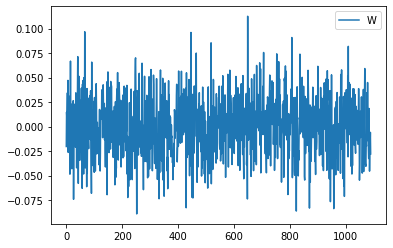

In [19]:
pd.DataFrame(model.weights[0][:,1], columns=['W']).plot.line()

In [20]:
import numpy as np

x = np.arange(1090)

source = pd.DataFrame({
  'x': x,
  'y': model.weights[0][:,0].numpy()
})

alt.Chart(source).mark_line().encode(x='x',y='y').interactive()

alt.Chart(...)

In [ ]:
model.weights[2]

In [ ]:
model.weights[4]